CUDA Available: False
Initializing Research Environment...

[TEST 1] Running SAHI Sliced Inference Analysis...
>> Processing tiles (this might take a few seconds)...
>> Detections found: 26


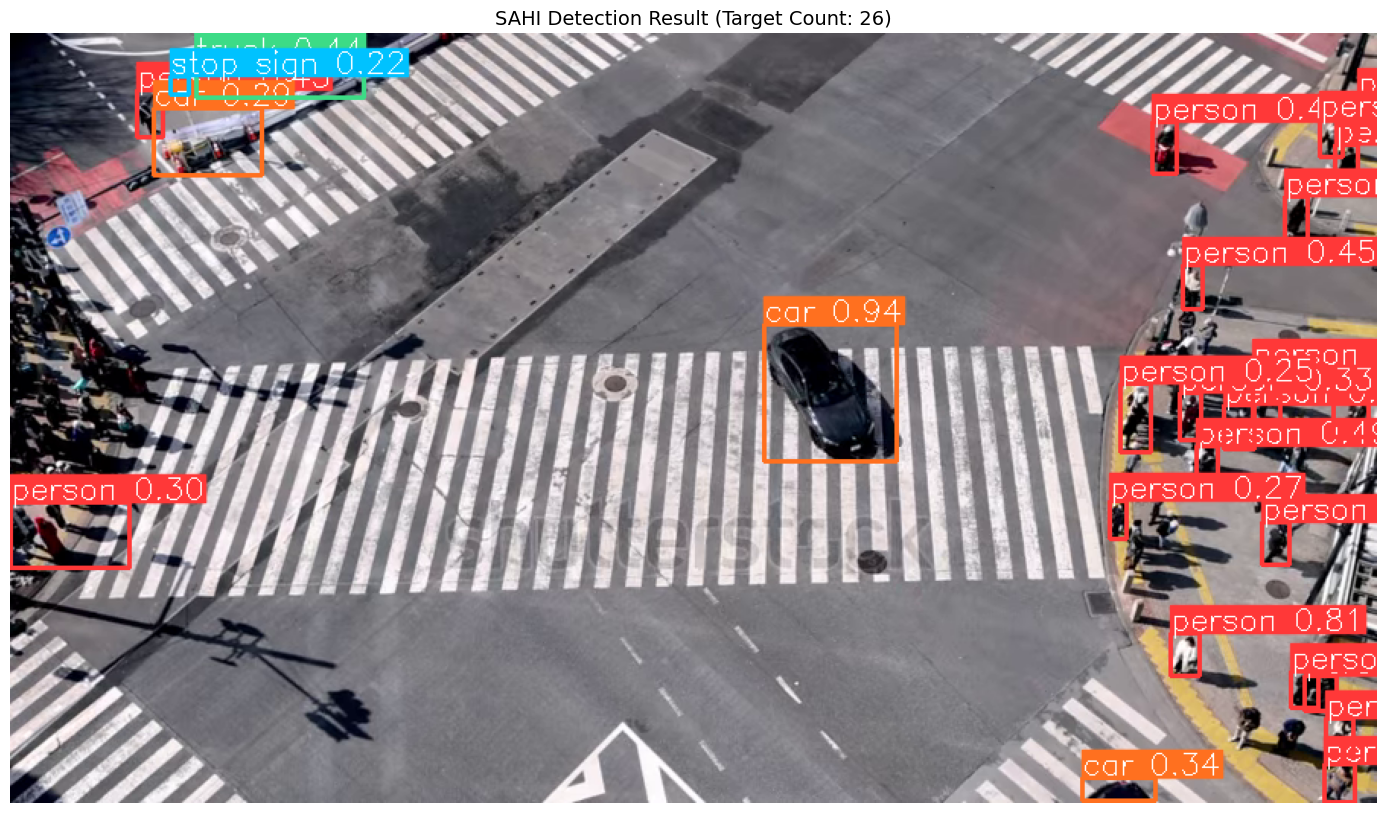


[TEST 2] Simulating Temporal Density Mathematics...
>> Objective: Visualize transformation from discrete detection points to continuous density field.


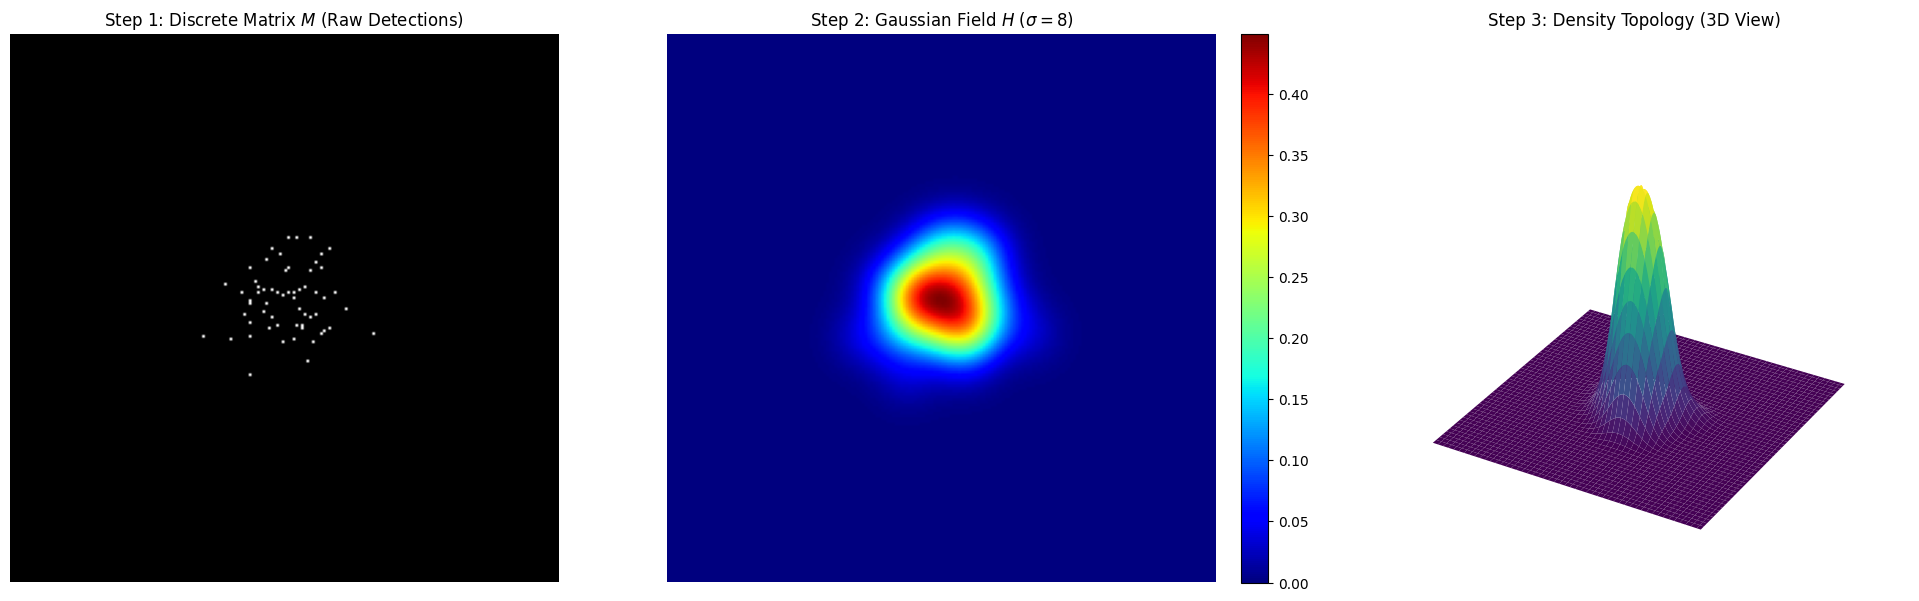

Research validation complete. Core algorithms verified.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D

# --- 1. CONFIGURATION & SETUP ---
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['axes.grid'] = False

# Paths (Relative to 'notebooks/' folder)
VIDEO_PATH = '../data/input/tokyo.mp4'
MODEL_PATH = '../yolov8x.pt'
SLICE_SIZE = 640

print(f"CUDA Available: {torch.cuda.is_available()}")
print("Initializing Research Environment...")

# --- 2. HELPER FUNCTIONS ---
def get_high_quality_frame(video_path):
    """Extracts a sharp frame from the video to test detection."""
    if not os.path.exists(video_path):
        print(f"Error: Video not found at {video_path}")
        return None
        
    cap = cv2.VideoCapture(video_path)
    # Skip prvih 50 frameova da ulovimo akciju
    for _ in range(50):
        ret, frame = cap.read()
    cap.release()
    
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return None

# --- 3. SAHI INFERENCE TEST (Small Object Detection) ---
print("\n[TEST 1] Running SAHI Sliced Inference Analysis...")
frame = get_high_quality_frame(VIDEO_PATH)

if frame is not None:
    # Initialize SAHI Model
    detection_model = AutoDetectionModel.from_pretrained(
        model_type='yolov8',
        model_path=MODEL_PATH,
        confidence_threshold=0.20,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Run Sliced Inference (The "Secret Sauce")
    print(">> Processing tiles (this might take a few seconds)...")
    result = get_sliced_prediction(
        frame,
        detection_model,
        slice_height=SLICE_SIZE,
        slice_width=SLICE_SIZE,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
        verbose=0
    )

    # Visualization
    print(f">> Detections found: {len(result.object_prediction_list)}")
    
    # Export temporary visual
    result.export_visuals(export_dir=".")
    if os.path.exists("prediction_visual.png"):
        visualized = cv2.imread("prediction_visual.png")
        visualized = cv2.cvtColor(visualized, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(18, 10))
        plt.imshow(visualized)
        plt.title(f"SAHI Detection Result (Target Count: {len(result.object_prediction_list)})", fontsize=14)
        plt.axis('off')
        plt.show()
        
        # Cleanup
        os.remove("prediction_visual.png")
else:
    print("Skipping SAHI test: No video frame loaded.")

# --- 4. MATHEMATICAL MODELING (Heatmap Logic) ---
print("\n[TEST 2] Simulating Temporal Density Mathematics...")
print(">> Objective: Visualize transformation from discrete detection points to continuous density field.")

# A. Create a blank spatial matrix (Simulation grid 200x200)
matrix = np.zeros((200, 200), dtype=np.float32)

# B. Inject discrete "Pedestrian" points (Simulating a crowd cluster)
# Using a random generator to create a realistic cluster
rng = np.random.default_rng(seed=42)
x_points = rng.normal(100, 15, 60).astype(int)
y_points = rng.normal(100, 15, 60).astype(int)

# Accumulate intensity (The "Brush" effect used in analytics.py)
for i in range(len(x_points)):
    if 0 <= x_points[i] < 200 and 0 <= y_points[i] < 200:
        matrix[y_points[i], x_points[i]] += 10.0

# C. Apply Gaussian Smoothing (The "Glow" effect)
# Formula: H = M * G(sigma)
sigma = 8
heatmap = gaussian_filter(matrix, sigma=sigma)

# D. Advanced Visualization (3 Subplots)
fig = plt.figure(figsize=(20, 6))

# Plot 1: Discrete Input
ax1 = fig.add_subplot(131)
ax1.imshow(matrix, cmap='gray')
ax1.set_title("Step 1: Discrete Matrix $M$ (Raw Detections)")
ax1.axis('off')

# Plot 2: Continuous Field
ax2 = fig.add_subplot(132)
im = ax2.imshow(heatmap, cmap='jet')
ax2.set_title(rf"Step 2: Gaussian Field $H$ ($\sigma={sigma}$)")
ax2.axis('off')
plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

# Plot 3: 3D Topology (Shows density peaks)
ax3 = fig.add_subplot(133, projection='3d')
X, Y = np.meshgrid(np.arange(200), np.arange(200))
surf = ax3.plot_surface(X, Y, heatmap, cmap='viridis', linewidth=0, antialiased=True)
ax3.set_title("Step 3: Density Topology (3D View)")
ax3.set_zlim(0, np.max(heatmap))
ax3.axis('off')

plt.tight_layout()
plt.show()

print("Research validation complete. Core algorithms verified.")